In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Kia.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Capital,Seri_Carens,Seri_Carnival,...,Model_2.9 CRDi Premium,Model_3.5 V6,Model_LS,Model_RS,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,569000,0.454545,0.194444,-0.788462,-0.696629,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,650000,1.000000,-0.972222,-2.701923,-1.303363,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,555000,0.818182,-0.972222,-2.701923,-1.058936,1.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,730000,0.818182,-0.055556,-0.923077,-1.297378,0.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,195000,-0.727273,-0.388889,-0.298077,0.299625,5.0,1.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_4516\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,49258.105259,2.512186e+09,50121.707647,34570.762977


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:03:36,881] A new study created in memory with name: no-name-ad0252a0-07f4-4651-ab27-8b0f3476a041
[I 2023-05-23 21:03:37,053] Trial 0 finished with value: 472685.7969427178 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.0005727214303471399, 'max_depth': 7, 'min_child_weight': 201}. Best is trial 0 with value: 472685.7969427178.
[I 2023-05-23 21:03:37,057] Trial 1 finished with value: 469270.0601792585 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0008218500751011054, 'max_depth': 6, 'min_child_weight': 256}. Best is trial 1 with value: 469270.0601792585.
[I 2023-05-23 21:03:37,059] Trial 3 finished with value: 470046.6839076763 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.0006107430774365891, 'max_depth': 9, 'min_child_weight': 142}. Best is trial 1 with value: 469270.0601792585.
[I 2023-05-23 21:03:37,060] Trial 4 finished with value: 288483.47110992897 and parameters: {'

[I 2023-05-23 21:03:38,206] Trial 29 finished with value: 62840.93776814698 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.22874277522037648, 'max_depth': 12, 'min_child_weight': 7}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:38,250] Trial 31 finished with value: 87135.28731198532 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.1938046484837666, 'max_depth': 12, 'min_child_weight': 55}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:38,327] Trial 32 finished with value: 83580.91247543924 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.2094702381774784, 'max_depth': 11, 'min_child_weight': 49}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:38,359] Trial 33 finished with value: 109161.99839444229 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.18837112923595378, 'max_depth': 15, 'min_child_weigh

[I 2023-05-23 21:03:39,976] Trial 59 finished with value: 114185.9747040497 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.14915245038292638, 'max_depth': 5, 'min_child_weight': 40}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:40,075] Trial 61 finished with value: 119718.21757921163 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1468292713455789, 'max_depth': 13, 'min_child_weight': 68}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:40,123] Trial 62 finished with value: 113099.54976352789 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.15432694133667066, 'max_depth': 13, 'min_child_weight': 68}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:40,177] Trial 64 finished with value: 98285.42050444245 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.16260106712567746, 'max_depth': 13, 'min_child_wei

[I 2023-05-23 21:03:41,990] Trial 89 finished with value: 54067.67351780961 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3800804226136665, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:42,068] Trial 91 finished with value: 55324.36515252591 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.37862321933634113, 'max_depth': 15, 'min_child_weight': 2}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:42,621] Trial 97 finished with value: 54693.966562611036 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3764767751181413, 'max_depth': 11, 'min_child_weight': 20}. Best is trial 24 with value: 49989.473675242756.
[I 2023-05-23 21:03:42,625] Trial 93 finished with value: 50234.92226824223 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.38351251639645145, 'max_depth': 9, 'min_child_weight'

[I 2023-05-23 21:03:44,282] Trial 120 finished with value: 52302.07971900228 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.337967685754265, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 92 with value: 49918.540600053326.
[I 2023-05-23 21:03:44,324] Trial 121 finished with value: 51987.62689857342 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.33476412411655865, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 92 with value: 49918.540600053326.
[I 2023-05-23 21:03:44,404] Trial 123 finished with value: 51620.62060784946 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.33938722280835054, 'max_depth': 10, 'min_child_weight': 13}. Best is trial 92 with value: 49918.540600053326.
[I 2023-05-23 21:03:44,439] Trial 122 finished with value: 50432.27682073824 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3334600811958159, 'max_depth': 10, 'min_child_weig

[I 2023-05-23 21:03:46,127] Trial 151 finished with value: 62891.04694473435 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2764466763265772, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 127 with value: 48614.14617406678.
[I 2023-05-23 21:03:46,152] Trial 150 finished with value: 62360.636565238274 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.27816439167434315, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 127 with value: 48614.14617406678.
[I 2023-05-23 21:03:46,347] Trial 152 finished with value: 60201.24355457096 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.29335411816240575, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 127 with value: 48614.14617406678.
[I 2023-05-23 21:03:46,417] Trial 153 finished with value: 56568.38527038471 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2718879245373965, 'max_depth': 8, 'min_child_weight

[I 2023-05-23 21:03:48,350] Trial 180 finished with value: 300179.47413649724 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.046461411131720476, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:48,379] Trial 182 finished with value: 54406.553434998 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4206657796415219, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:48,434] Trial 181 finished with value: 50270.60820639048 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4157210366265872, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:48,458] Trial 183 finished with value: 53146.95084887677 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4177089380219248, 'max_depth': 7, 'min_child_weight': 

[I 2023-05-23 21:03:50,559] Trial 210 finished with value: 52020.9787497885 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.311388835947894, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:50,603] Trial 211 finished with value: 49163.640877665195 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.38637206233864263, 'max_depth': 8, 'min_child_weight': 8}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:50,640] Trial 213 finished with value: 48322.076519374576 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3872179489819027, 'max_depth': 8, 'min_child_weight': 10}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:50,669] Trial 212 finished with value: 48839.540922110544 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3852162640029037, 'max_depth': 8, 'min_child_weight'

[I 2023-05-23 21:03:52,730] Trial 240 finished with value: 52671.47230858264 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4190586672419241, 'max_depth': 8, 'min_child_weight': 22}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:52,771] Trial 241 finished with value: 53981.71470493548 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.44165067327712165, 'max_depth': 8, 'min_child_weight': 23}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:52,808] Trial 242 finished with value: 53855.595920532636 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4255949466967957, 'max_depth': 8, 'min_child_weight': 23}. Best is trial 156 with value: 47361.89905935191.
[I 2023-05-23 21:03:52,832] Trial 243 finished with value: 53431.995825381826 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4330213538444925, 'max_depth': 8, 'min_child_weig

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 46862.7015
Best params:
	colsample_bytree: 0.9
	subsample: 0.7
	learning_rate: 0.3692543193945653
	max_depth: 8
	min_child_weight: 9


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [8,12],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.9],
               'subsample': [0.7],
               'min_child_weight': [9]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 9, 'n_estimators': 500, 'subsample': 0.7}
{'TestDeger': 52534.83103021568, 'MSE': 2599558475.569841, 'RMSE': 50985.865448865734, 'MAE': 34567.324262152775}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9180756908891277

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8832439268113759

In [16]:
marka_model = joblib.dump(grid_final_model, "Kia.pkl")

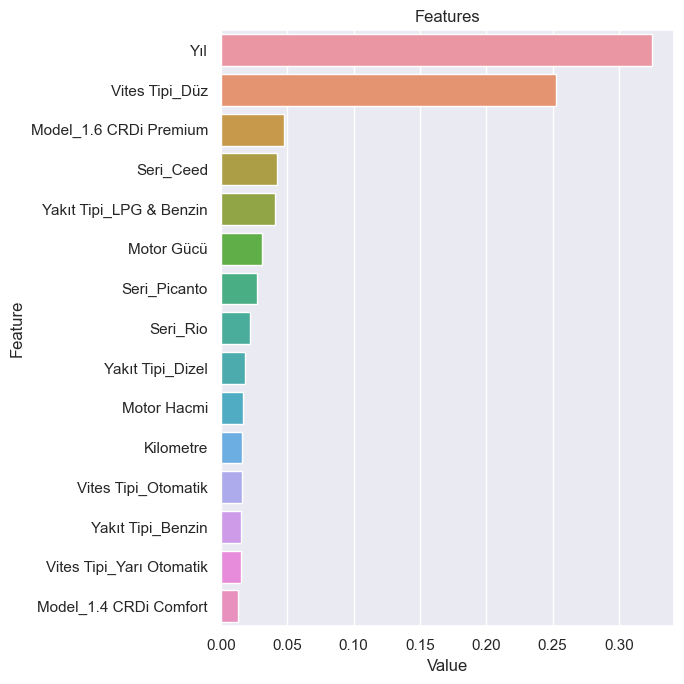

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)